# Notebook for running 1D-TDSE C code from Python
Author: Tadeas Nemec, 2023

### Load libraries and files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
### Main Python TDSE helper script, contains C structures, function wrappers etc.
from PythonTDSE import *

### Path to compiled dynamic C library
path_to_DLL = os.path.realpath(os.path.join(os.getcwd(), "build/libsingleTDSE.dylib"))

### TDSE DLL class declaration
DLL = TDSE_DLL(path_to_DLL)

### TDSE variables initialization

We instantiate a C-compatible ```inputs_def``` class that is in fact C types structure. This strucure (class) contains all the necessary variables for the C 1D-TDSE code. Then we initialize it from an HDF5 input file.

In [2]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def
filename = "results.h5"
inputs.init_inputs(filename)
inputs.init_prints(path_to_DLL)

Initialize temporal grid and initial field. There are two ways how to do it. Either you specify the result file from the CUPRAD code and select a particular field or you provide custom electric field and time grids.

In [3]:
### Set indeces in the field:
z_i = 75
r_i = 512
### Initialize field and time in the input
inputs.init_time_and_field(filename, z_i, r_i)

We can visualize and check the fields by plotting.

We use functions ```get_tgrid()``` and ```get_Efield()``` to obtain numpy arrays with the corresponding data, if saved into the structure. 

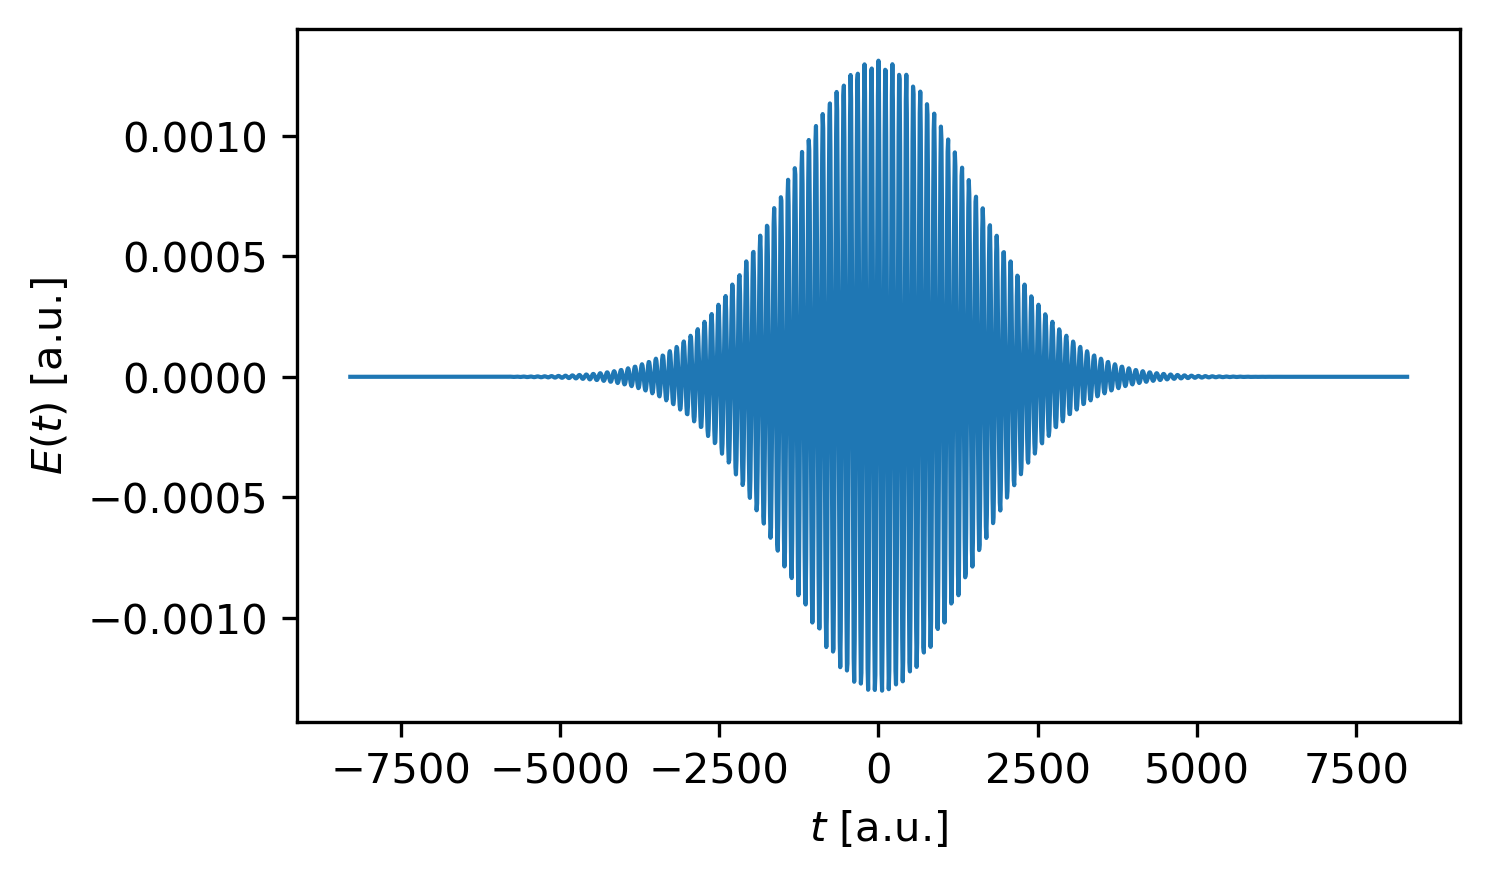

In [4]:
t = inputs.get_tgrid()
E = inputs.get_Efield()

plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]", linewidth = 1.)

### Ground state computation

We need to first compute the ground state (GS) wavefunction for the propagation. We call the C function ```Initialise_grid_and_ground_state``` and pass the pointer to ```inputs``` using Ctypes function ```byref```. This is conveniently encapsulated in the ```init_GS``` function. We need to include the path to the C library.

**Note**: it prints the progress of the GS energy computation.

In [5]:
DLL.init_GS(inputs)

We can check if the GS has been found by plotting it.

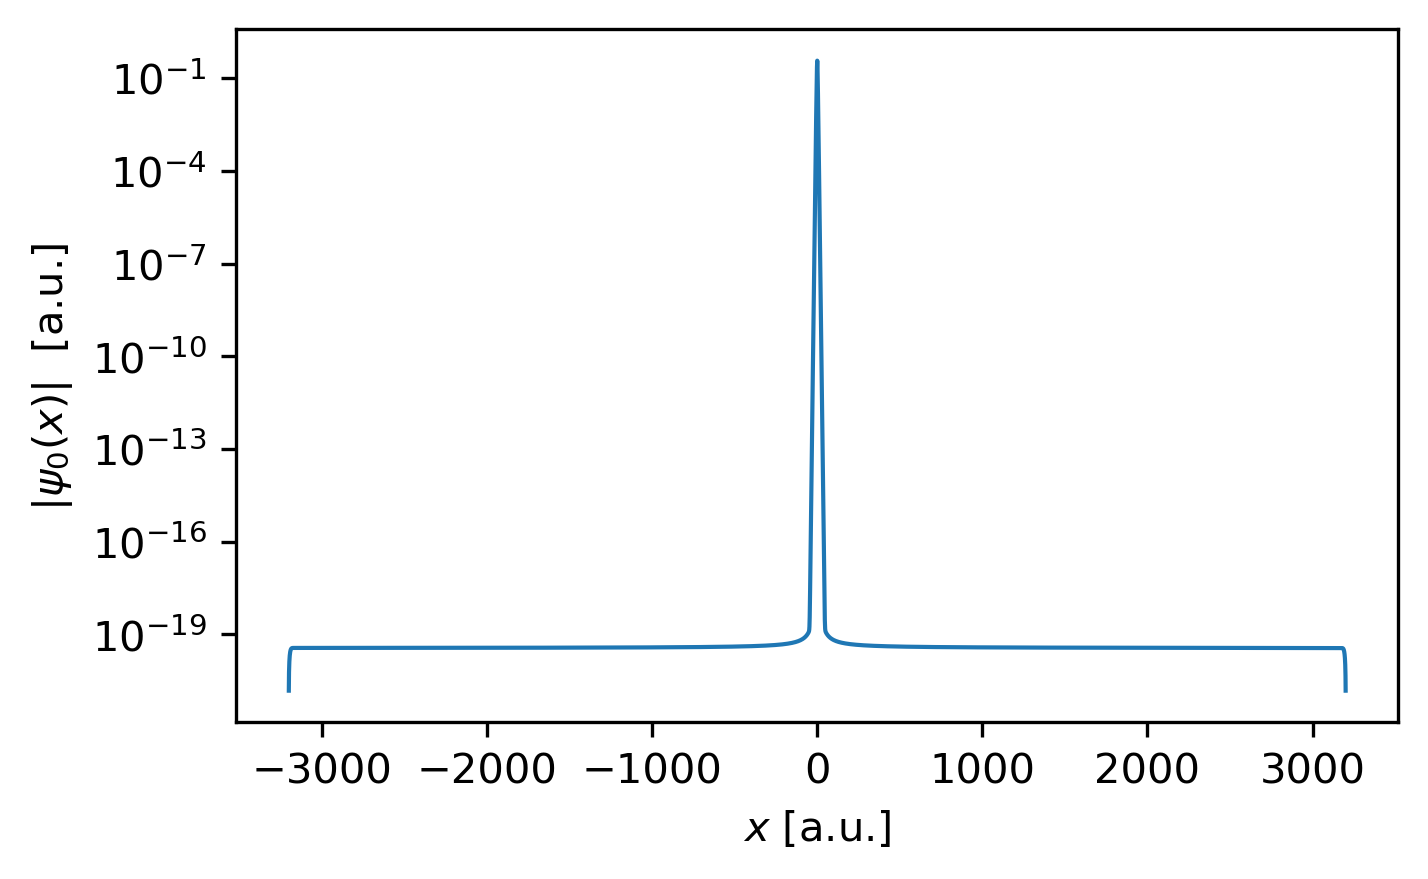

In [6]:
psi0 = inputs.get_GS()
x = inputs.get_xgrid()

plot(x, np.abs(psi0), plot_scale="log", x_label=r"$x$ [a.u.]", y_label = r"|$\psi_0(x)|$  [a.u.]", linewidth = 1.)

### Propagation of the wavefunction

Now that we have found the GS, we can run the 1D-TDSE. We first define the output structure of type ```outputs_def``` that will store the result of the TDSE computation. 

**Remark**: This part of the code is computationally heavy and may take several minutes to finish, depending on the size of the input field. 

In [7]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

We may now plot the result of the computation. We can try plotting the expectation value of x, $<x(t)>$, during the propagation.

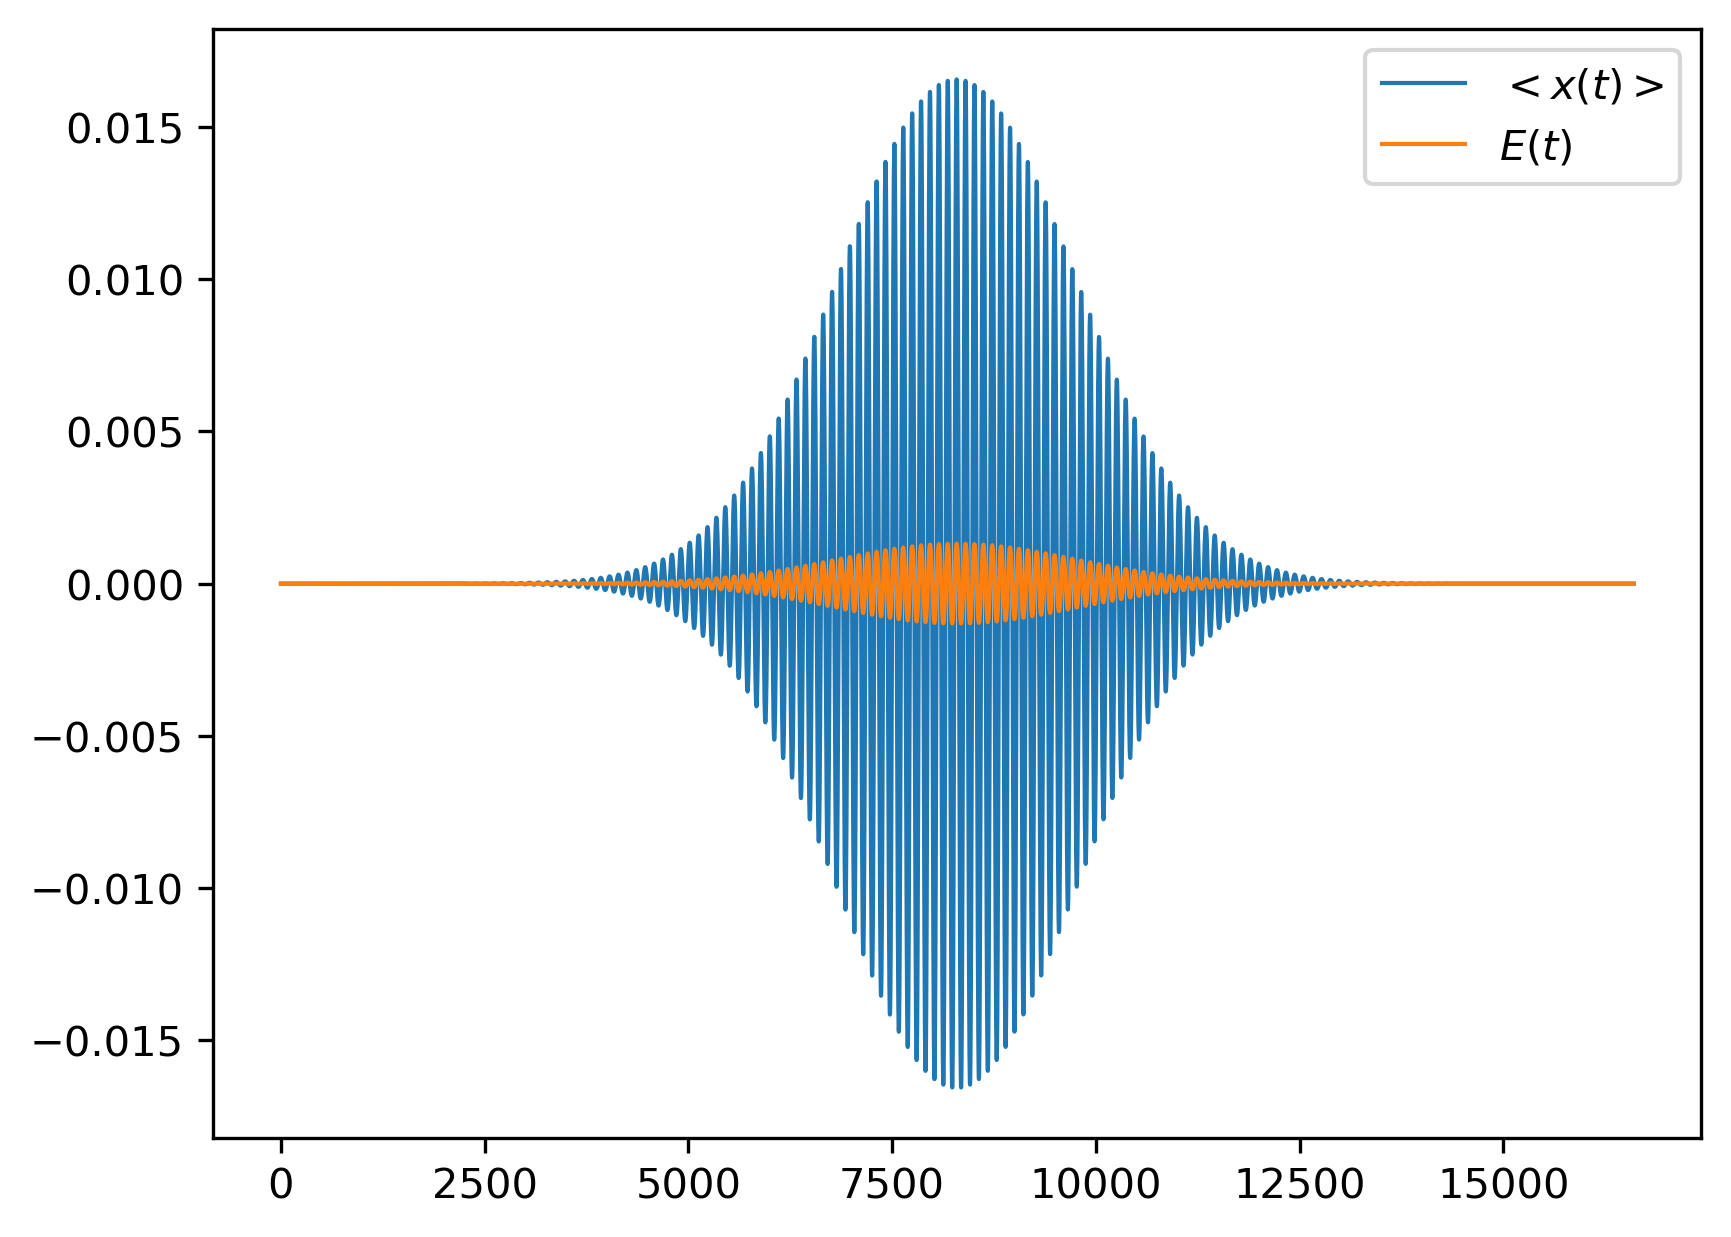

In [8]:
fig = plt.figure()
fig.dpi = 300

t = output.get_tgrid()
x = output.get_expval()
E = output.get_Efield()
plt.plot(t, x, label = r"$<x(t)>$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1)
plt.legend()
plt.show()

### Custom field

We show an example how to run the 1D-TDSE with custom numerical electric provided by the Python high level API.

In [9]:
### Create instance of input structure
inputs2 = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs2.init_default_inputs()


Custom field definition and plot

In [10]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs2.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


Plot the chirped pulse

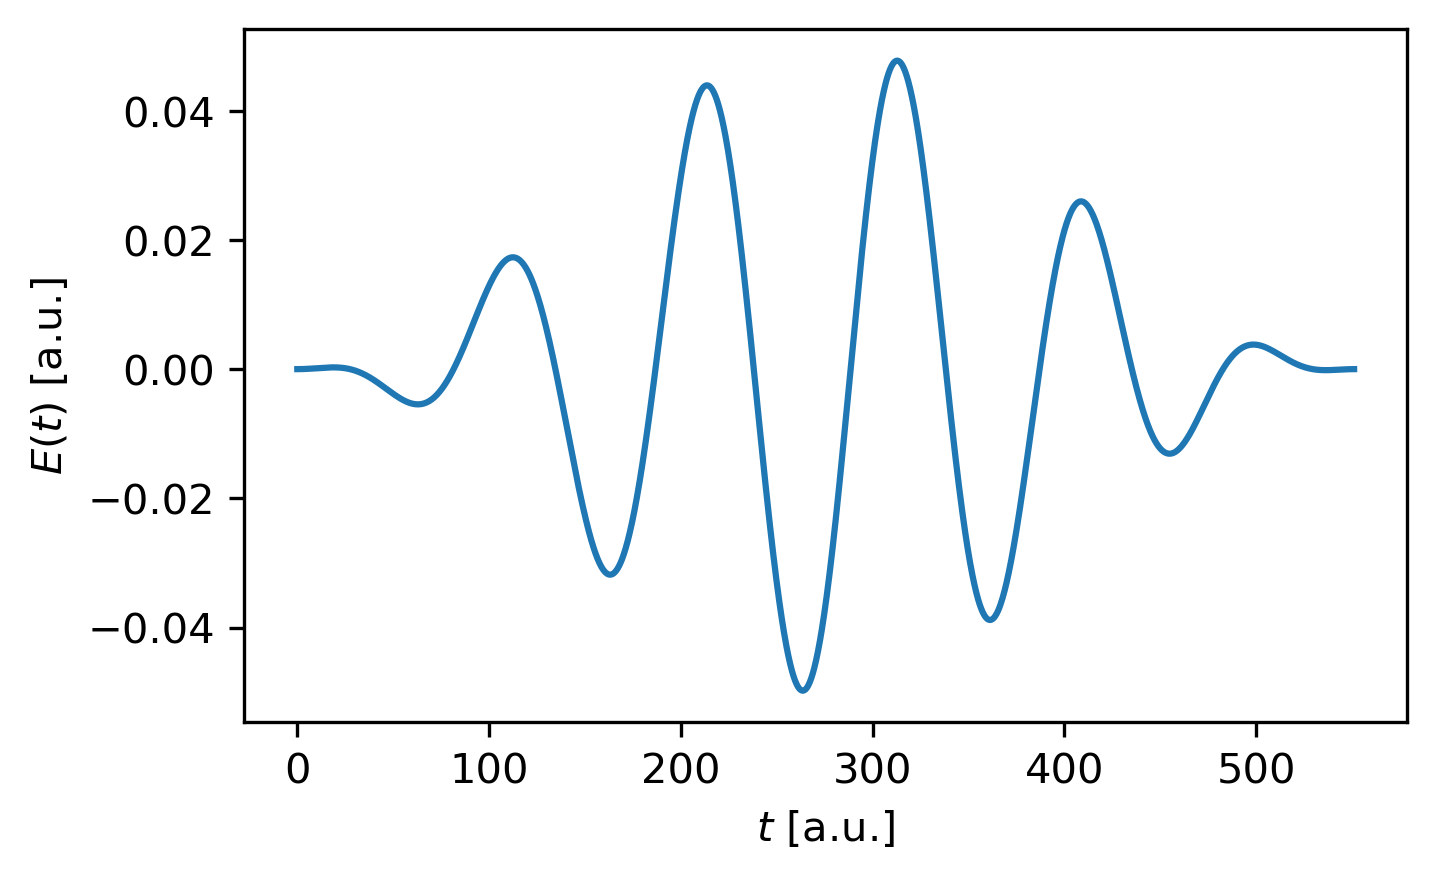

In [11]:
plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [12]:
inputs2.init_time_and_field(E = E, t = t)

Compute the GS

In [13]:
DLL.init_GS(inputs2)

Again check the GS

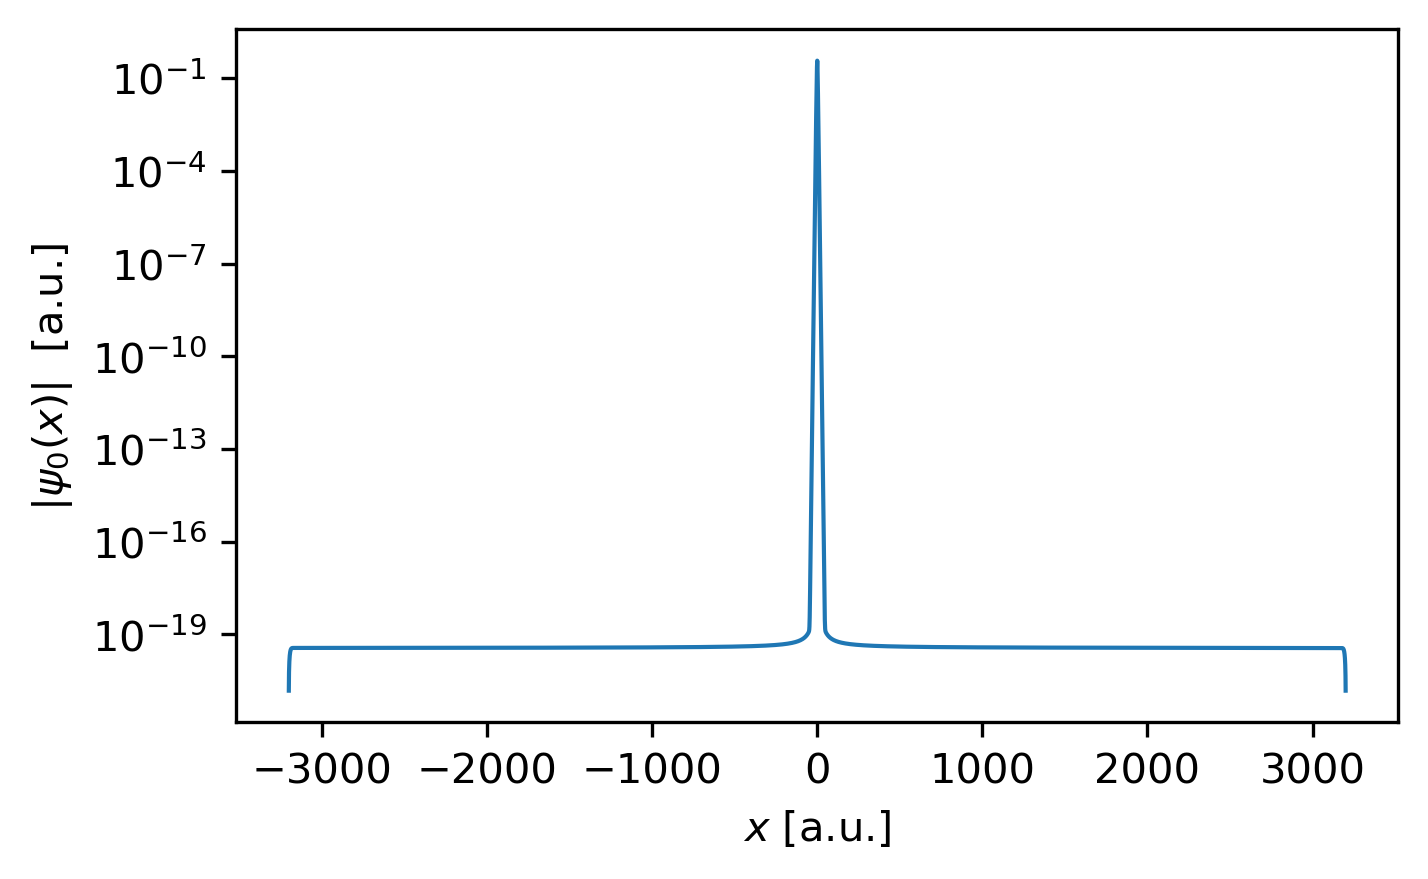

In [14]:
psi0 = inputs2.get_GS()
x = inputs2.get_xgrid()

plot(x, np.abs(psi0), plot_scale="log", x_label=r"$x$ [a.u.]", y_label = r"|$\psi_0(x)|$  [a.u.]", linewidth = 1.)

Propagate the field

In [15]:
output2 = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs2, output2)

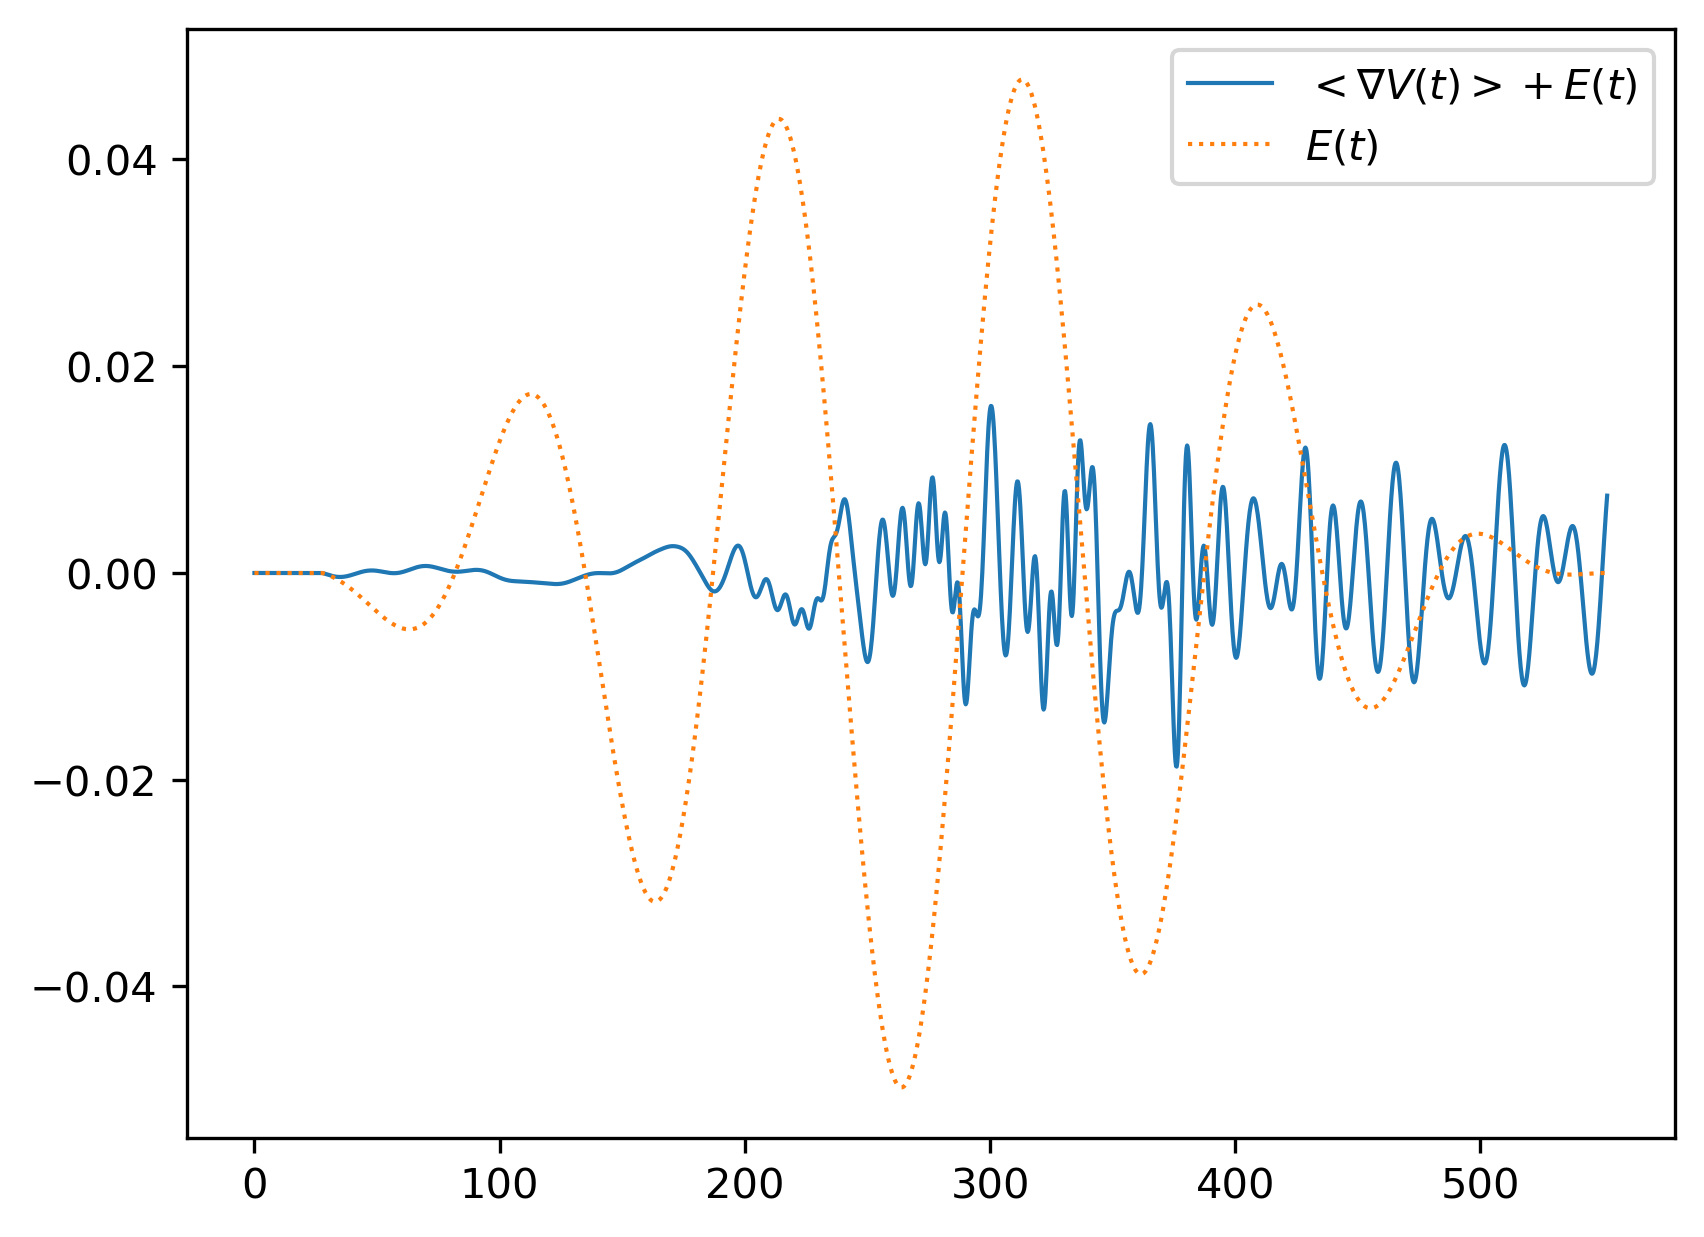

In [16]:
t = output2.get_tgrid()
sourceterm = output2.get_sourceterm()
E = output2.get_Efield()
fig = plt.figure()
fig.dpi = 300
plt.plot(t, sourceterm, label = r"$<\nabla V(t)> + E(t)$", linewidth = 1)
plt.plot(t, E, label = r"$E(t)$", linewidth = 1, linestyle = ":")
plt.legend()
plt.show()

Compare the spectrum of the source term computed in CTDSE using FFTW with Numpy FFT. The FFT is normalized by a factor $dt/\sqrt{2 \pi}$.

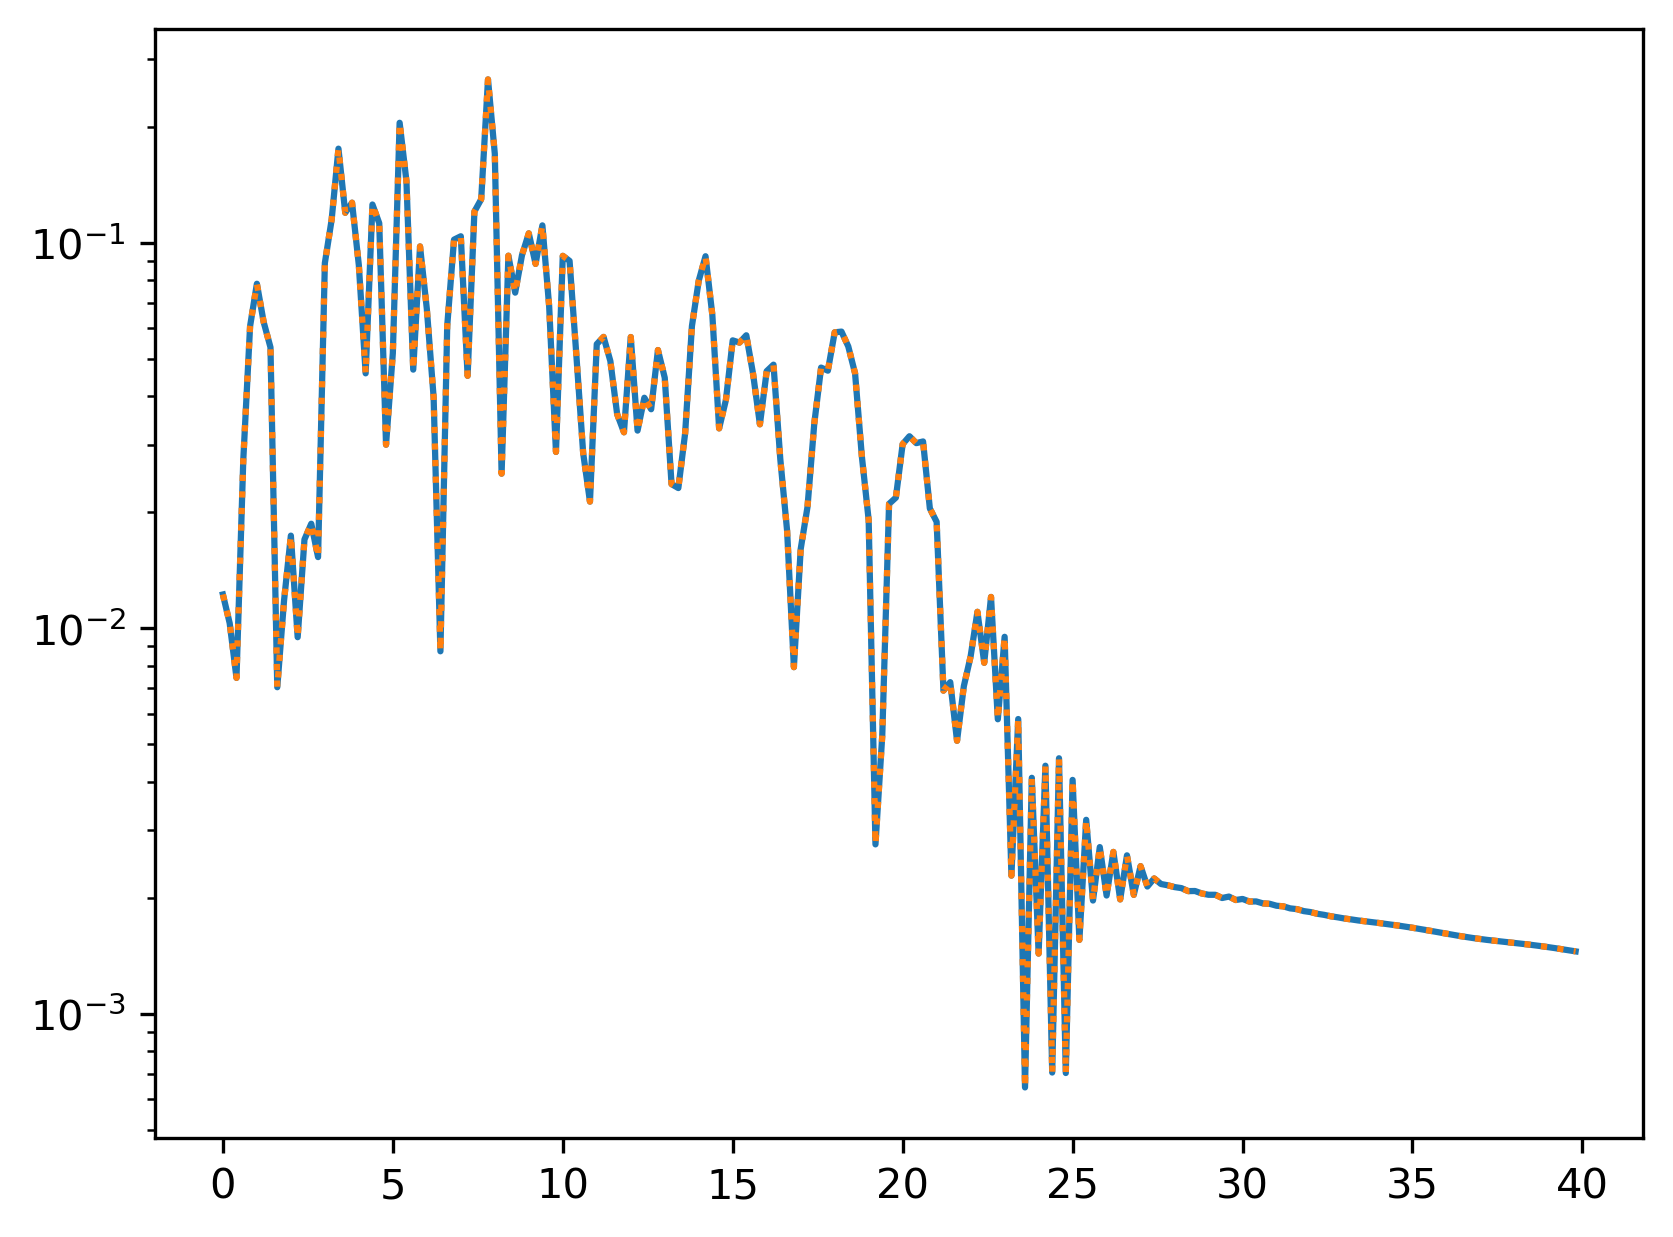

In [21]:
norm = (t[1]-t[0])/np.sqrt(2*np.pi)
omegas = output2.get_omegagrid()[0:200]/omega_0

fig = plt.figure()
fig.dpi = 300
plt.semilogy(omegas, norm*np.abs(np.fft.fft(sourceterm))[0:200])
plt.semilogy(omegas, np.abs(output2.get_Fsourceterm())[0:200], linestyle = ":")

plt.show()

### Plot wavefunction in $t$

In [3]:
### Create instance of input structure
inputs3 = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs3.init_default_inputs()

Set writing and the timestep for wavefunction writing

In [4]:
### Set writing true
inputs3.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs3.analy.tprint = c_double(10.)

In [5]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs3.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


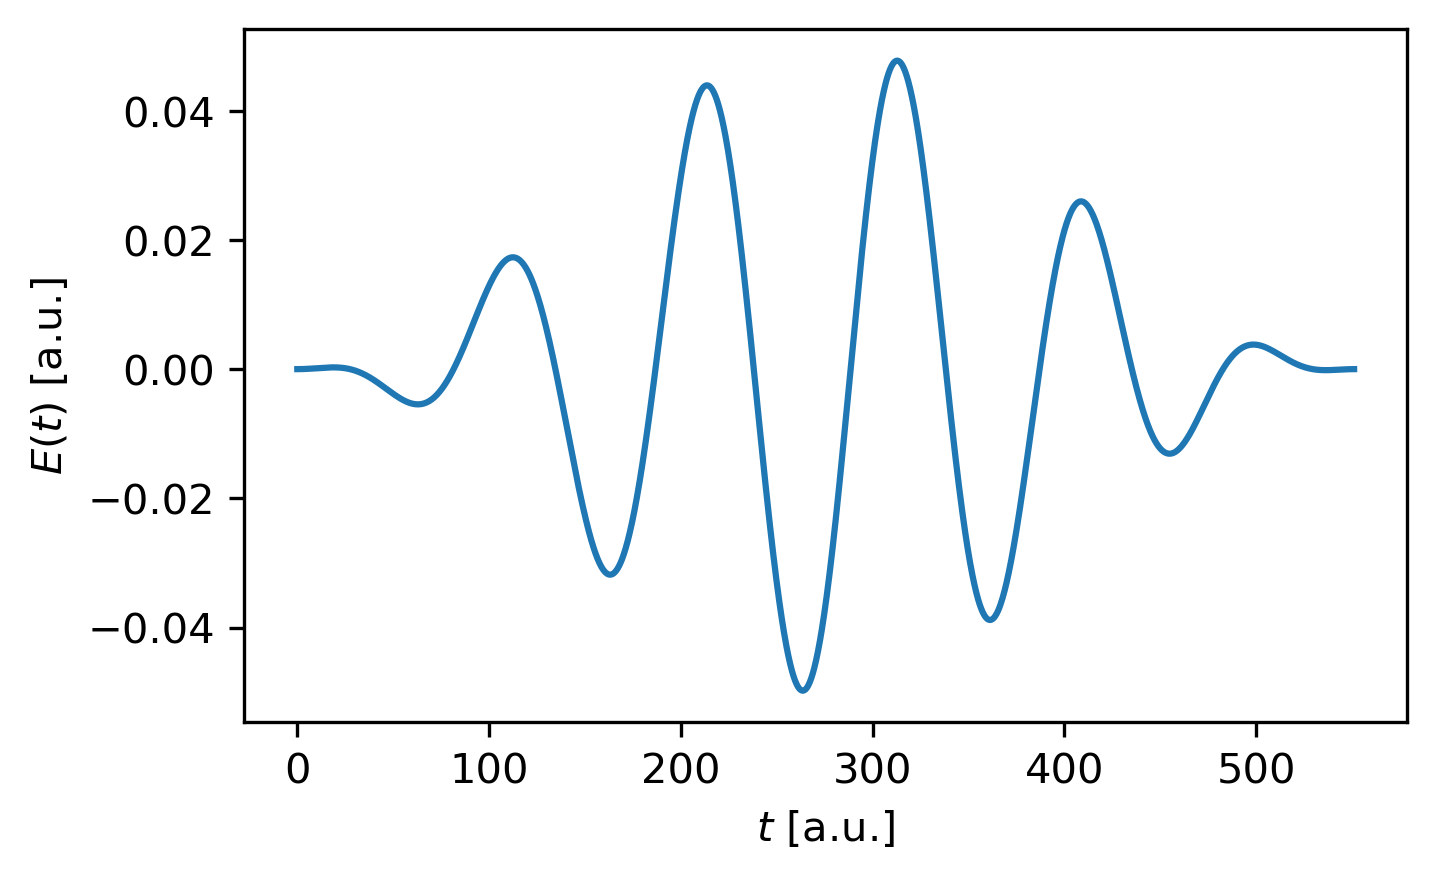

In [6]:
plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [7]:
inputs3.init_time_and_field(E = E, t = t)
DLL.init_GS(inputs3)

Call 1DTDSE and write the wavefunction

In [8]:
output3 = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs3, output3)

Load the wavefunction. We get a complex NDarray.

In [9]:
### Load numpy array from the wavefunction, given the number of wavefunctions
### and given the size of the array for 1 wavefunction
tgrid, x, wavefunction = output3.get_wavefunction(inputs3)
print("Wavefunction size: ", wavefunction.shape)

Wavefunction size:  (56, 16001)


Select plotting range along $x$-axis:

In [10]:
x_range = (np.abs(x) < 1000.1)

Plot colormap of the wavefunction evolution (absolute value of $\psi$).

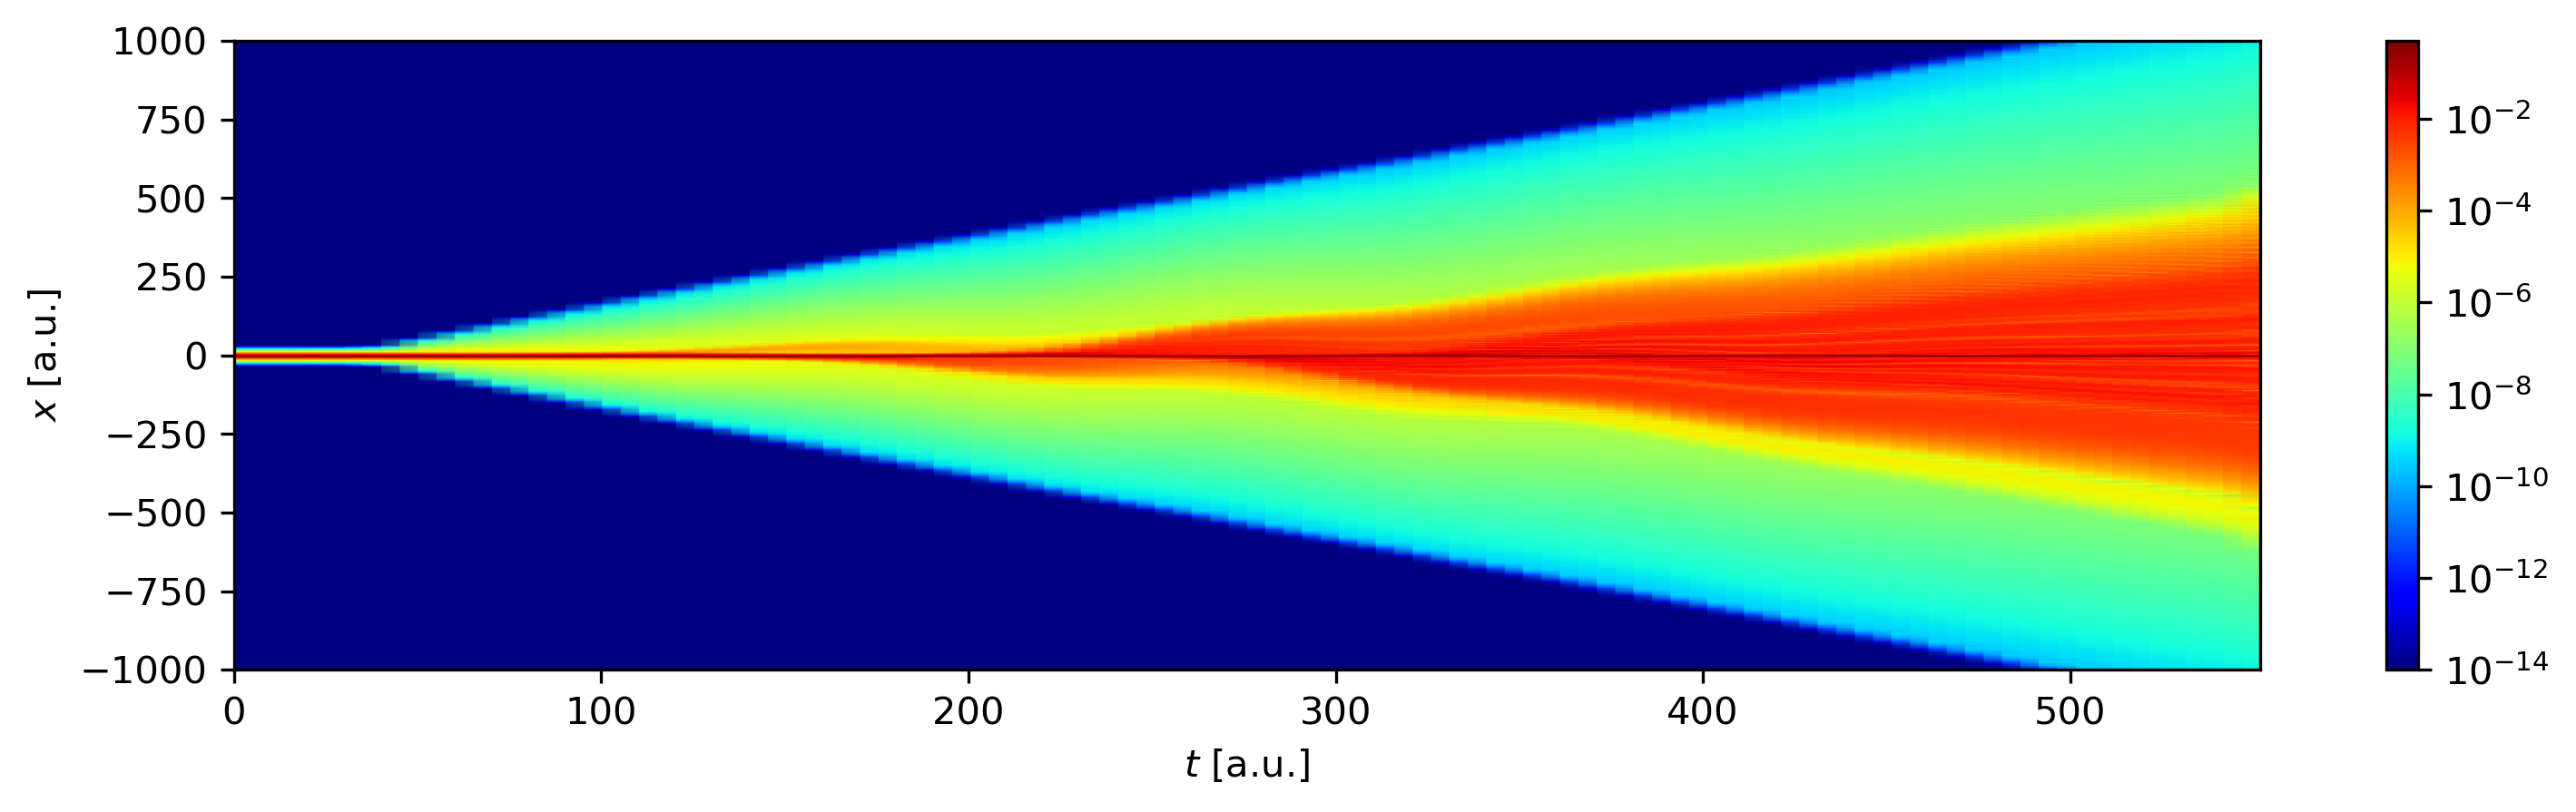

In [11]:
plot_colormap(x[x_range], tgrid, np.transpose(np.abs(wavefunction))[x_range], x_label=r"$t$ [a.u.]", y_label=r"$x$ [a.u.]", plot_scale="log", z_max=0.5)

Plot final wavefunction $\psi(t = T)$

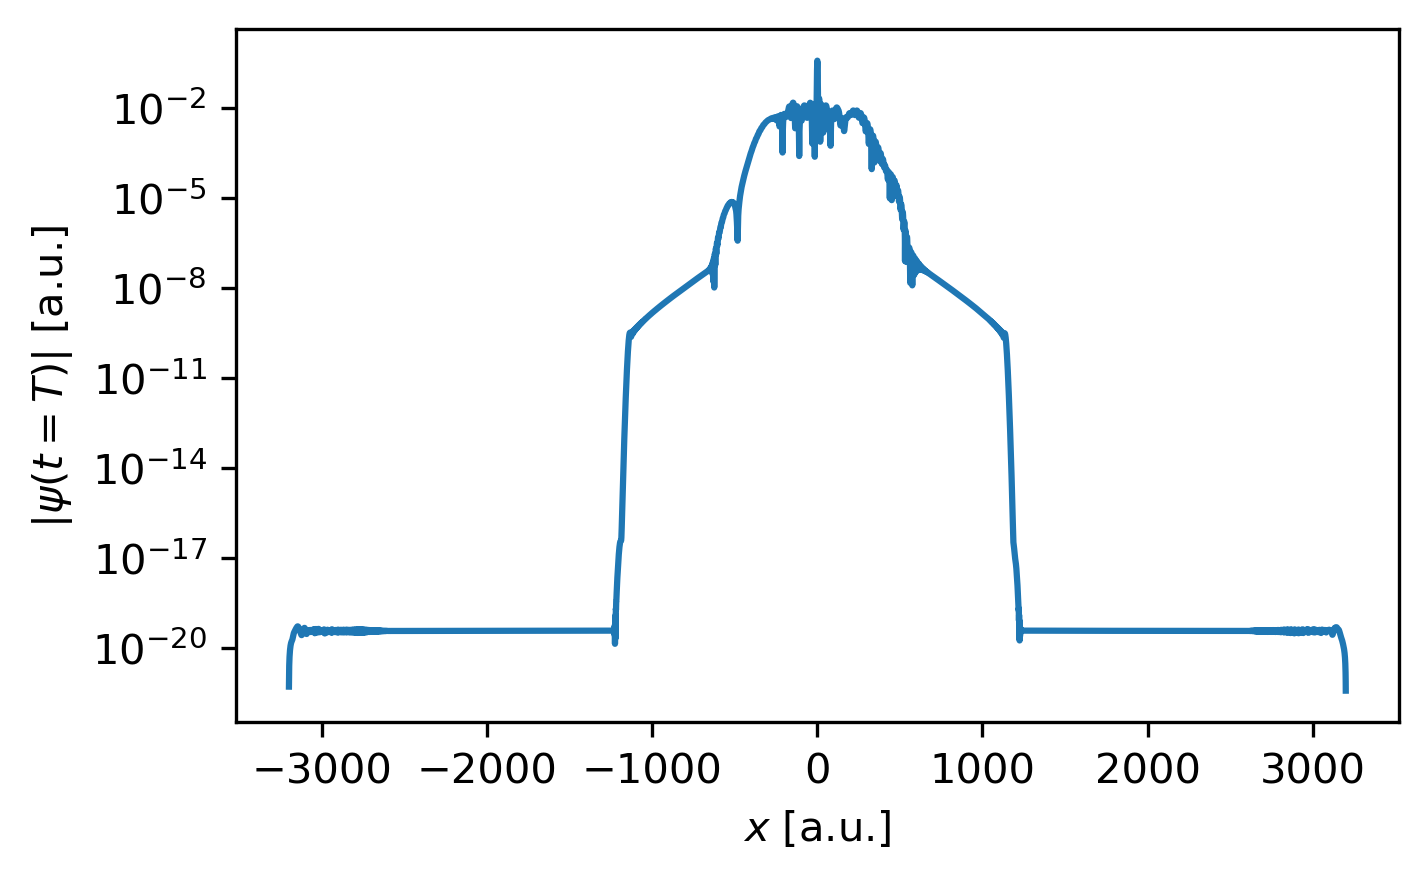

In [12]:
psi = wavefunction[-1]
plot(x, np.abs(psi), plot_scale="log", x_label=r"$x$ [a.u.]", y_label=r"$|\psi(t = T)|$ [a.u.]")


### Computing photoelectron spectrum (PES) for the final $\psi$

Save the final wavefunction pointer

In [13]:
### Setting final wavefunction for the PES computation
psi_final = output3.psi[len(wavefunction)-1]

Compute PSE using the wrapper function, provided input structure and $\psi(t = T)$.

In [14]:
E, PSE = DLL.compute_PES(inputs3, psi_final)

Plotting PES

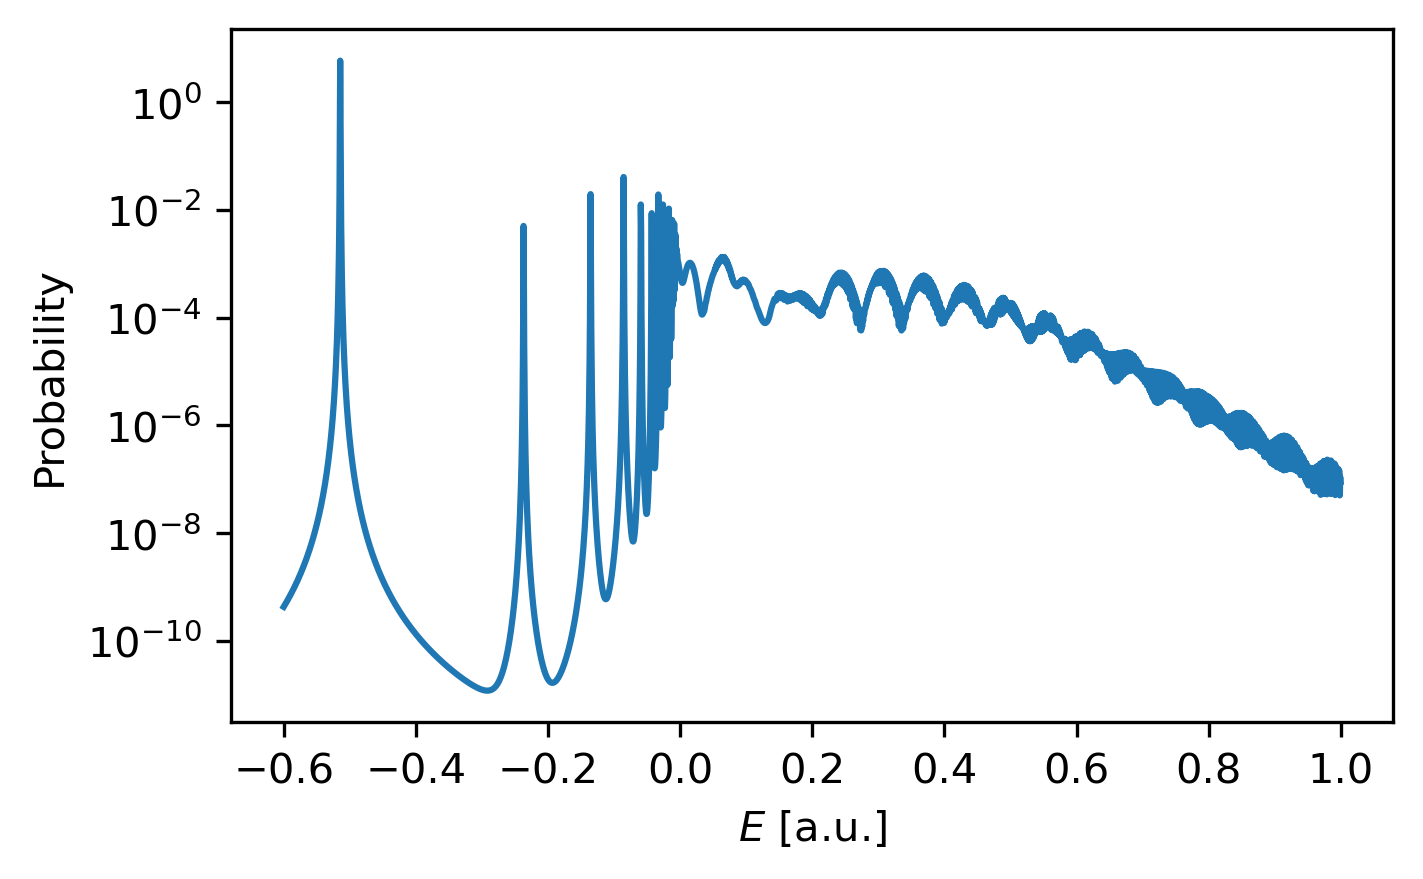

In [15]:
### Set range for plotting PES below 1 a.u. of energy
E_range = (E < 1.)

### Do the plot
plot((E[E_range]), PSE[E_range], y_label="Probability", x_label=r"$E$ [a.u.]", plot_scale="log")

Free wavefunction in the outputs.

In [16]:
DLL.free_mtrx(output3.psi, len(wavefunction))

### Print Gabor transform of $<\nabla V>$

In [17]:
grad_V = output3.get_sourceterm()
dt = output3.tgrid[1]-output3.tgrid[0]
Nt = output3.Nt
omega_0 = 0.057
omega_max = omega_0*35
T = output3.tgrid[Nt-1]

In [18]:
t, omegas, gabor = DLL.gabor_transform(grad_V, dt, Nt, omega_max, 100., 400, 1000, a=8)

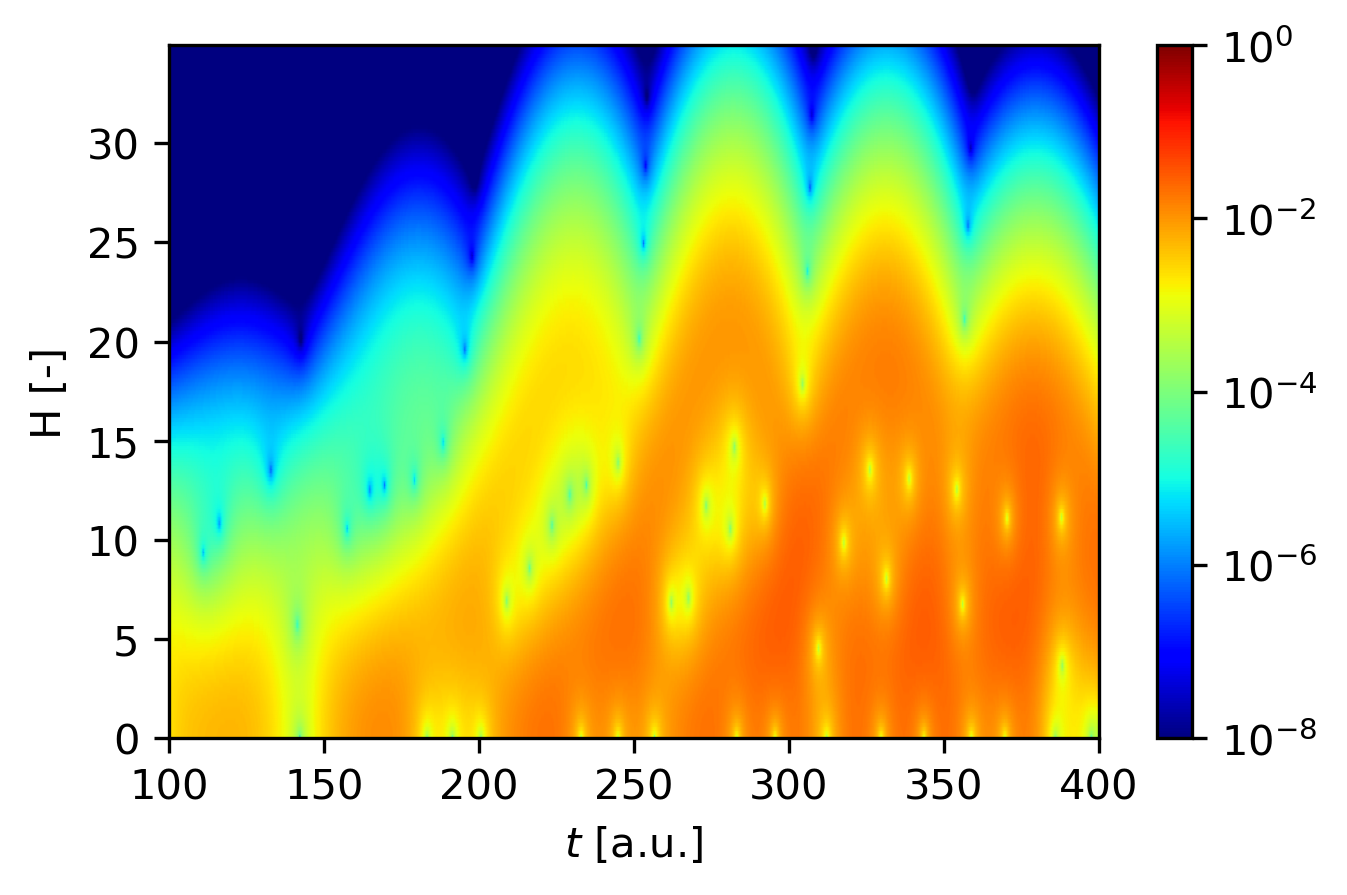

In [19]:
plot_colormap(omegas/omega_0, t, gabor, z_min=1e-8, figsize=(5, 3), x_label=r"$t$ [a.u.]", y_label=r"H [-]")

## Free memory

The structures should be released after the termination of the Python kernel. We can free the memory using ```delete(DLL)``` methods of ```inputs_def``` and ```outputs_def``` structures.

We must provide the DLL class for the C wrapper.

In [20]:
inputs.delete(DLL)
inputs2.delete(DLL)
inputs3.delete(DLL)

In [21]:
output.delete(DLL)
output2.delete(DLL)
output3.delete(DLL)

## Save output and input to HDF5

In [2]:
### Create instance of input structure
inputs = inputs_def()

### Initialize inputs, initialization functions are methods of inputs_def

### First we need to set the default inputs (can be modified with kwargs)
inputs.init_default_inputs()

In [3]:
### Set writing true
inputs.analy.writewft = c_int(1)
### Set wavefunction writing each 10 au in time
inputs.analy.tprint = c_double(10.)

In [4]:
### Fundamental frequency
omega_0 = 0.057
### Period
T = 2*np.pi/omega_0
### Pulse length
T_max = 5*T
### Number of time points
N_t = int(T_max/inputs.dt) + 1
### Temporal grid
t = np.linspace(0, T_max, N_t)
### Sine squared envelope
sin_2 = lambda t: np.sin(np.pi*t/T_max)**2
### Chirp
chirp = 1e-5*t**2
### Field magnitude
E_0 = 0.05
### Field
E = E_0*sin_2(t)*np.cos(omega_0*t + chirp)

assert(len(E) == len(t))
print("Size of the field and time grids: ", N_t)

Size of the field and time grids:  2205


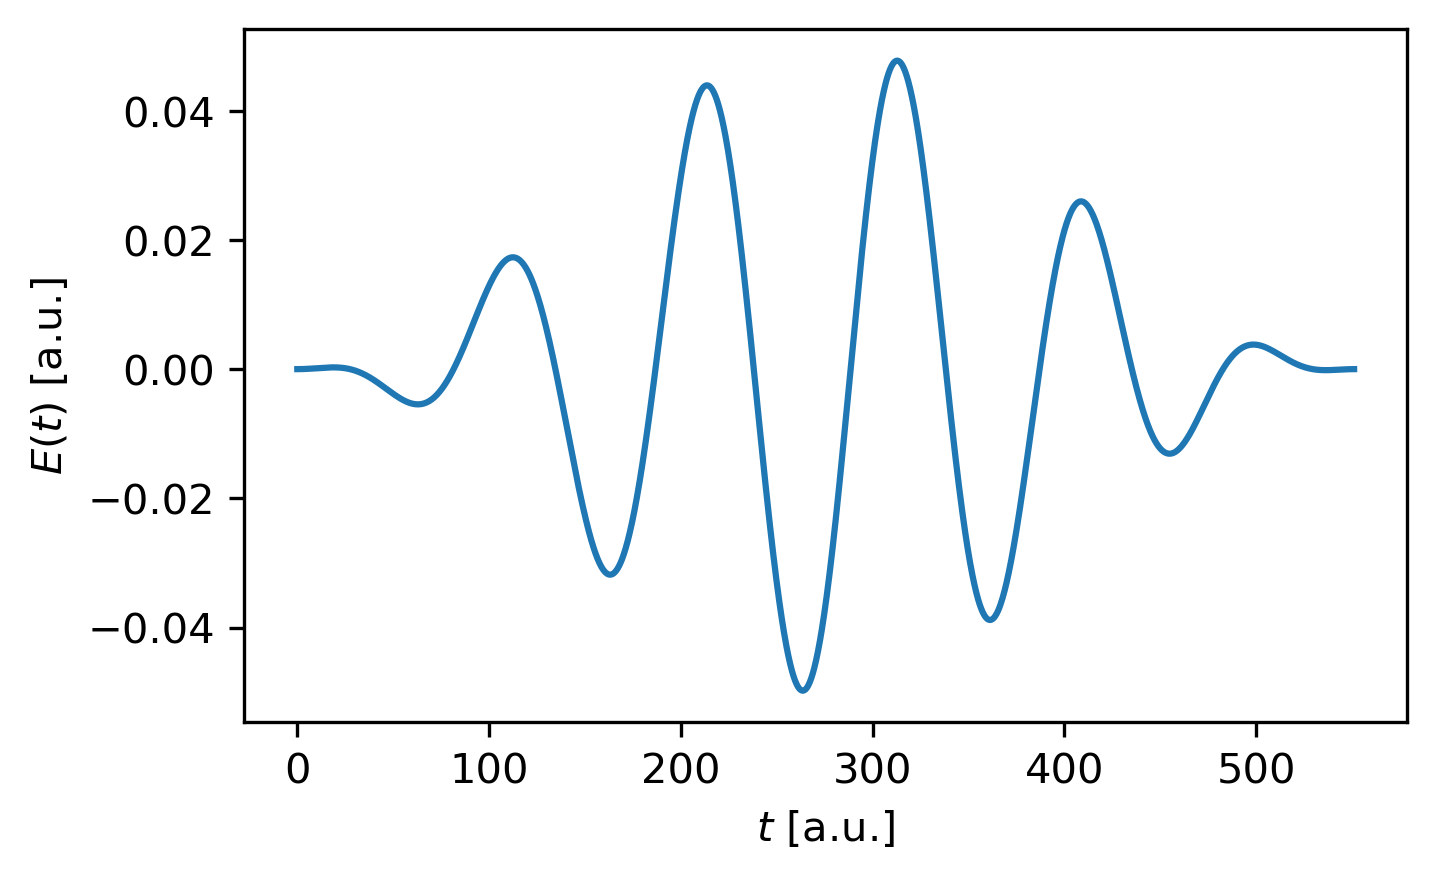

In [5]:
plot(t, E, y_label=r"$E(t)$ [a.u.]", x_label=r"$t$ [a.u.]")

In [6]:
inputs.init_time_and_field(E = E, t = t)
DLL.init_GS(inputs)

Save the inputs

In [7]:
inputs.save_to_hdf5("test.h5")

Compute CTDSE

In [8]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Save the outputs. If kwarg ```inputs = inputs```, then it writes the wavefunction into the HDF5 file, if available by ```write_wft = 1```. The wavefunction is saved within the HDF5 file as 2 datasets: real and imaginary part of the wavefunction for the predefined discretization in time. 

In [9]:
output.save_to_hdf5("test.h5", inputs=inputs)

Delete memory

In [10]:
inputs.delete(DLL)
output.delete(DLL)

Delete wavefunction

In [11]:
wavefunction = output.get_wavefunction(inputs, grids=False)
DLL.free_mtrx(output.psi, len(wavefunction))

We can load back the input from the HDF5 file for new computations using the aforementioned ```init_inputs()``` method.

In [12]:
inputs = inputs_def()
inputs.init_inputs("test.h5")

Check if loaded correctly

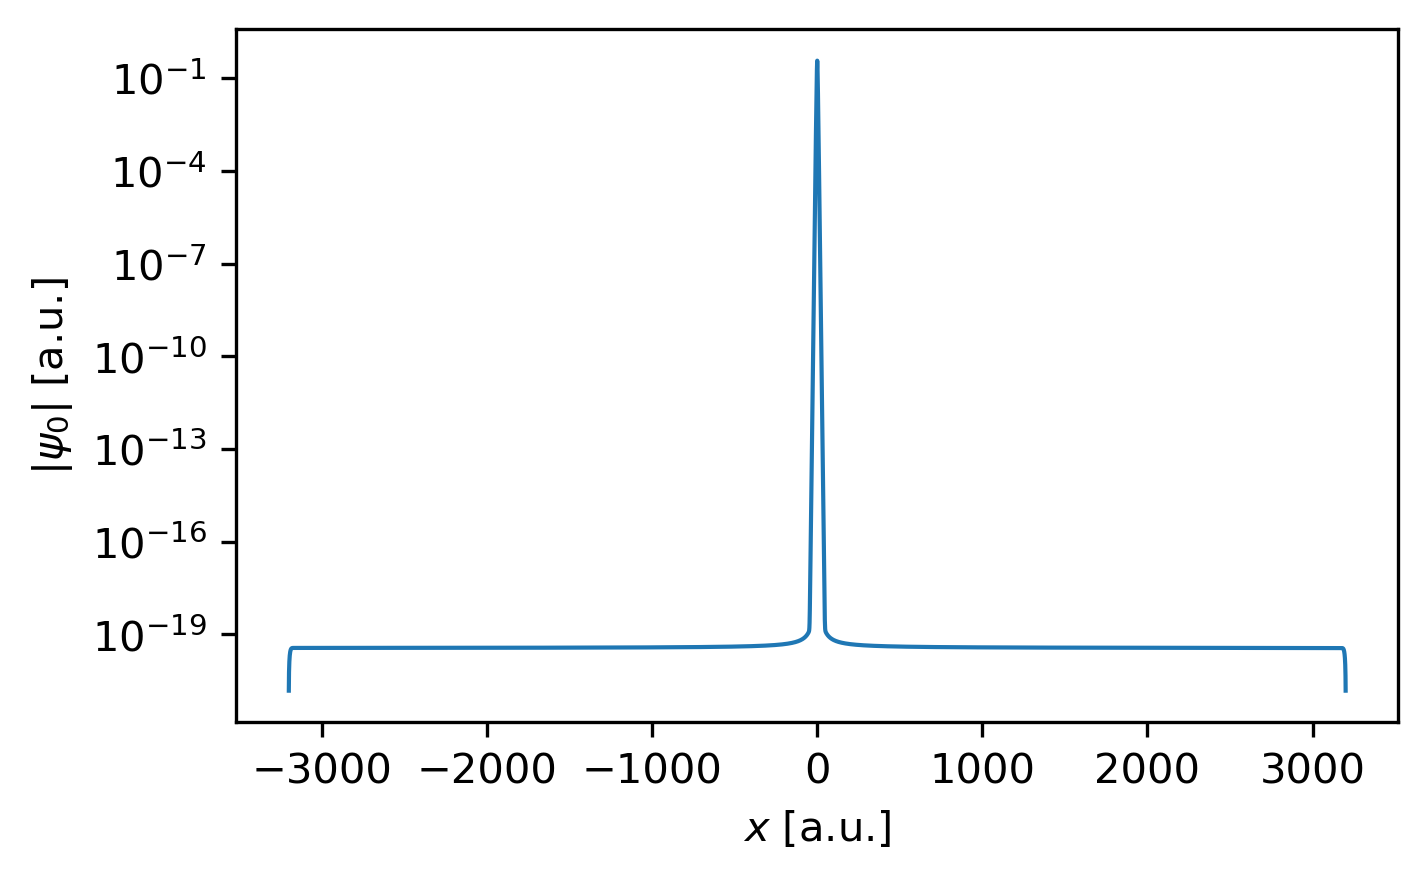

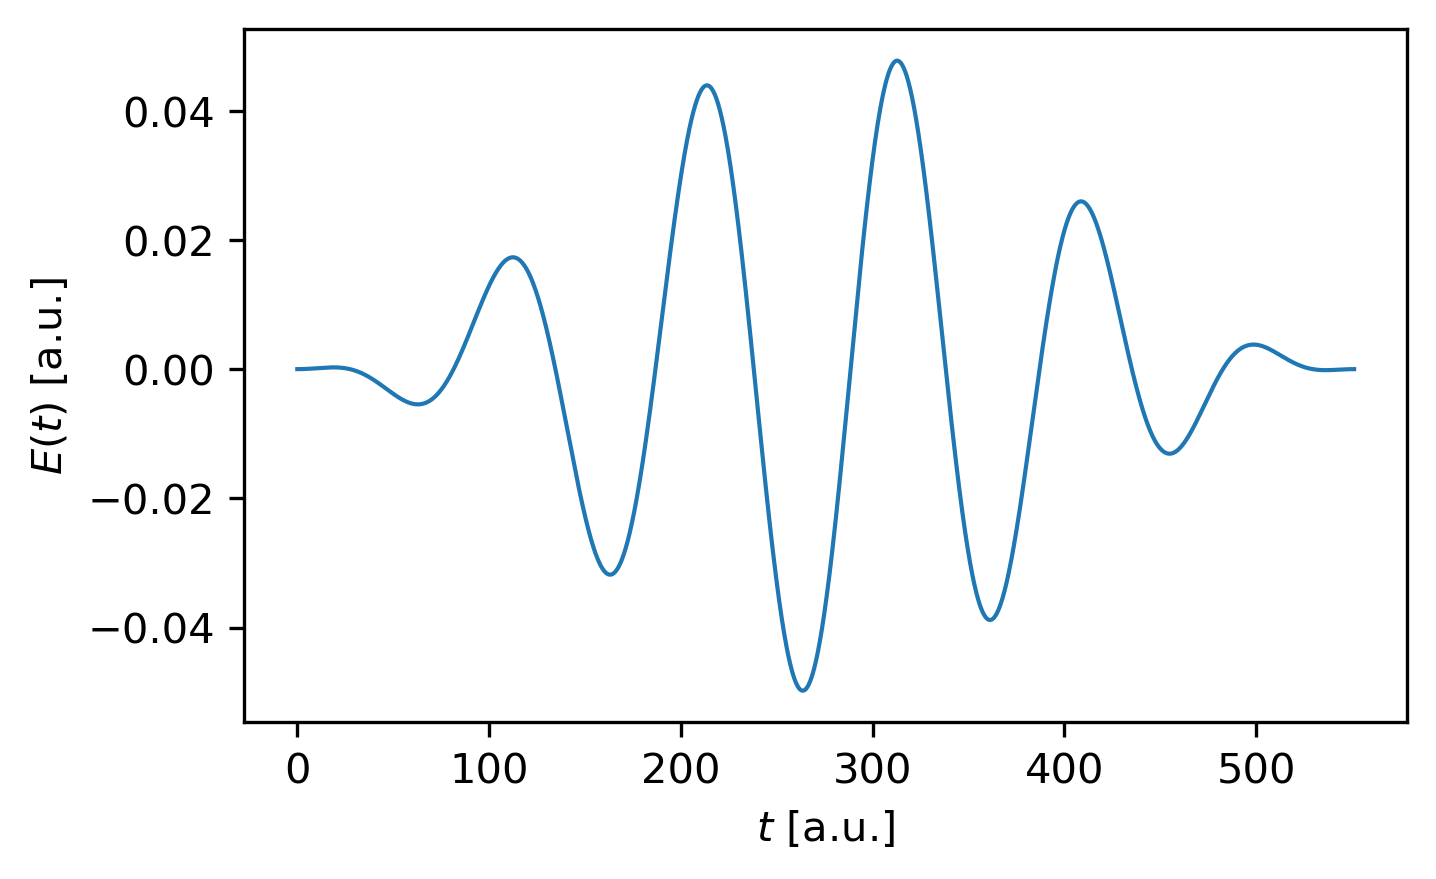

In [17]:
plot(inputs.get_xgrid(), np.abs(inputs.get_GS()), plot_scale = "log", linewidth = 1., x_label=r"$x$ [a.u.]", y_label=r"$|\psi_0|$ [a.u.]")
plot(inputs.get_tgrid(), inputs.get_Efield(), linewidth = 1., x_label=r"$t$ [a.u.]", y_label=r"$E(t)$ [a.u.]")

Propagate the loaded inputs

In [18]:
output = outputs_def()
### Call 1D TDSE from the inputs
DLL.call1DTDSE(inputs, output)

Plot data

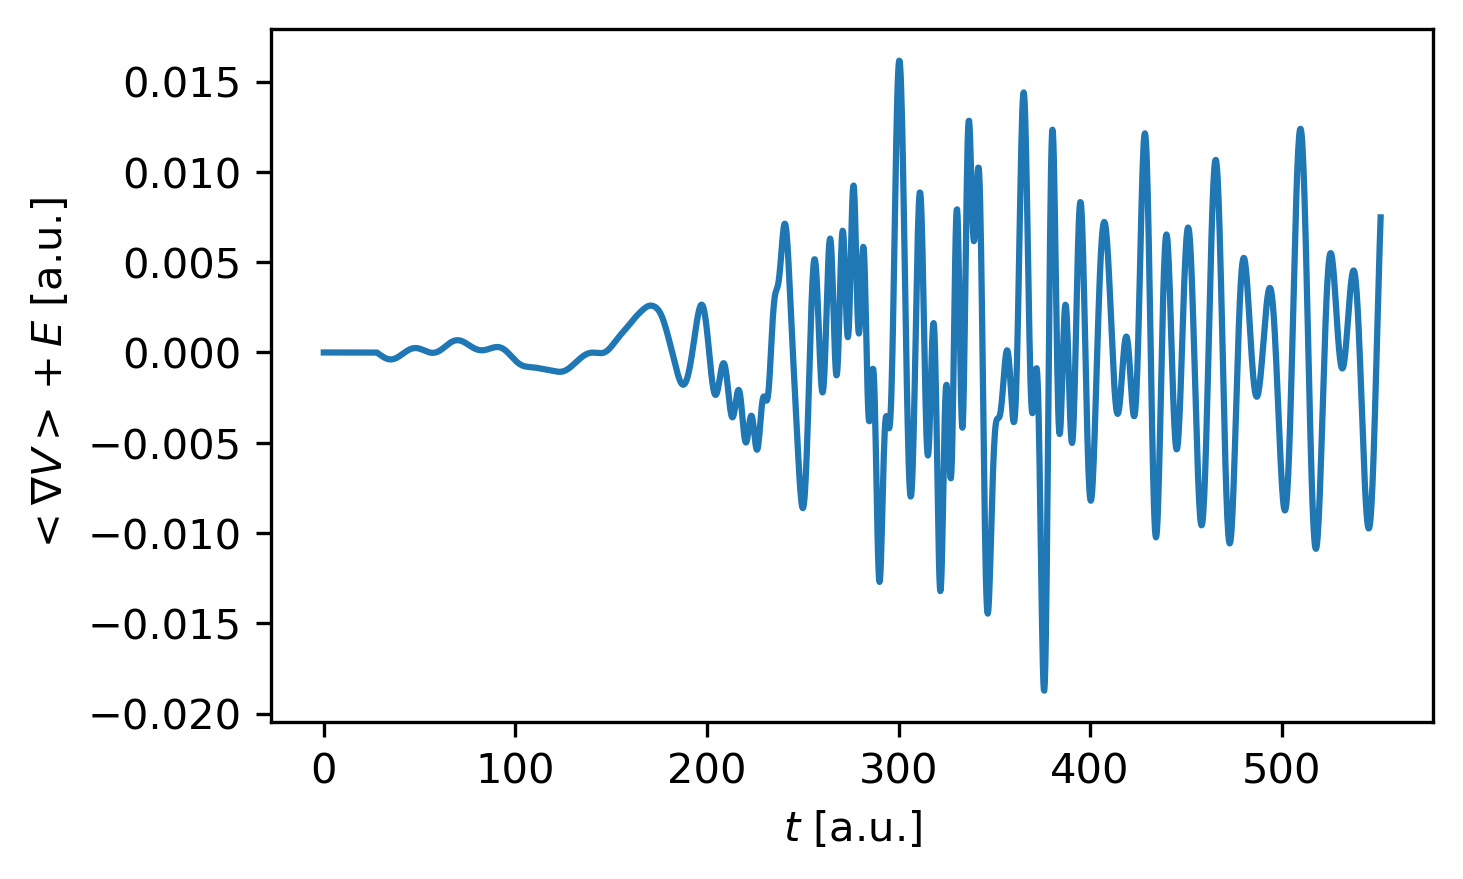

In [19]:
plot(output.get_tgrid(), output.get_sourceterm(), x_label=r"$t$ [a.u.]", y_label=r"$<\nabla V> + E$ [a.u.]")

Delete data

In [20]:
wavefunction = output.get_wavefunction(inputs, grids=False)
DLL.free_mtrx(output.psi, len(wavefunction))
inputs.delete(DLL)
output.delete(DLL)